# Определение стационарности и порядка интегрирования временных рядов ожидаемой продолжительности жизни по странам

**Оглавление**<a id='toc0_'></a>    
- [Проверка на стационарность временных рядов ожидаемой продолжительности жизни по странам](#toc1_)    
- [Определение порядка интегрирования временных рядов ожидаемой продолжительности жизни по странам](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [71]:
import sys
# Добавим папку с корнем проекта в список системных директорий, чтобы Python видел путь к папке utils
sys.path.append('..')

In [72]:
import pandas as pd
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import kpss

from utils.constants import (
    F, 
)
from utils.prepare_data import (
    get_location_codes,
    get_location_time_series,
    get_location_by_code,
    get_train_test_data,
)

%matplotlib inline

from warnings import simplefilter
simplefilter('ignore')

In [ ]:
# Загрузим таблицу
data = pd.read_csv(
    '../data/cumulative_life_expectancy_prepared.csv'
)

## <a id='toc1_'></a>[Проверка на стационарность временных рядов ожидаемой продолжительности жизни по странам](#toc0_)

Стационарность означает, что сам временной ряд может меняться с течением времени, \
однако статистические свойства генерирующего его процесса \
[математическое ожидание](https://ru.wikipedia.org/wiki/%D0%9C%D0%B0%D1%82%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BE%D0%B6%D0%B8%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5), [дисперсия](https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D1%81%D0%BF%D0%B5%D1%80%D1%81%D0%B8%D1%8F_%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D0%BE%D0%B9_%D0%B2%D0%B5%D0%BB%D0%B8%D1%87%D0%B8%D0%BD%D1%8B) и [совместное распределение вероятности](https://ru.wikipedia.org/wiki/%D0%A1%D0%BE%D0%B2%D0%BC%D0%B5%D1%81%D1%82%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5)
не меняются.

- В нашем случае ряд будет **стационарным**, если у него отсутствуют тренд и сезонность, \
а математическое ожидание и дисперсия при этом остаются постоянными на протяжении всего периода времени.

- У **нестационарного** временного ряда статистики (математическое ожидание и дисперсия) \
будут изменяться со временем, а сам ряд будет иметь сезонность и/или тренд.

По разложению рядов для разных стран, полученнуму в [08_decomposition.ipynb](./08_decomposition.ipynb)
видно, что везде есть только тренд.\
То есть, для рассматриваемого случая, есть предположение, что все или большинство рядов нестационарны.\
Проверим это с помощью статистического теста **Квятковского-Филлипса-Шмидта-Шина** (Kwiatkowski-Phillips-Schmidt-Shin, **KPSS**-тест). 

В тесте формулируется две гипотезы:

- Нулевая гипотеза ($H_0$): \
временной ряд стационарный, то есть не имеет тренда и сезонной компоненты, и данные скорее случайны.
- Альтернативная гипотеза ($H_1$): \
временной ряд нестационарный, то есть имеет некоторый тренд и сезонную компоненту;

Выберем уровень значимости $p-value$ равным $0.05$, то есть 5%.

Для проведения теста будем использовать метод [kpss()](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html) из пакета `statsmodels`.

In [ ]:
# Коды всех стран
location_codes = get_location_codes(data)

# Выделим данные тренировочной части, 
# так как корректно исследовать их, а не всю выборку
train_data, test_data = get_train_test_data(data)

# Словарь с данными результатов теста
stationarity_dict = {
    # Код страны
    F.SpatialDimValueCode.value: [], 
    # Флаг-вывод, является ли ряд стационарным
    'IsStationarity': [], 
}


def is_time_series_stationarity(time_series: pd.DataFrame) -> bool:
    """Определяет, является ли ряд стационарным для уровня занчимости p-value = 0.5

    Args:
        time_series (pd.DataFrame): временной ряд

    Returns:
        bool: является ли ряд стационарным
    """
    kpss_test = kpss(time_series, regression='c', nlags='auto')
    test_stat, p_value, lags_used, critical_values = kpss_test
    # Тестовая статистика больше критического значения и p-value < 0.05
    if (test_stat > critical_values['5%'] and p_value < 0.05):
        # В этом случае мы отвергаем нулевую гипотезу - ряд нестационарен
        return False
    return True
    

# Для каждой страны проведем тест и запомним результат
for code in location_codes:
    # Временной ряд для тренировочных данных
    location_time_series_train = get_location_time_series(train_data, code) 
    
    stationarity_dict[F.SpatialDimValueCode.value].append(code)
    
    is_stationarity = is_time_series_stationarity(location_time_series_train)
    stationarity_dict['IsStationarity'].append(is_stationarity)


# Посмотрим на количество стационарных и нестационарных рядов
stationarity_data = pd.DataFrame(stationarity_dict)
stationarity_data['IsStationarity'].value_counts()

IsStationarity
False    166
True      15
Name: count, dtype: int64

Посмотрим на графики распределения рядов, которые согласно тесту стационарны.

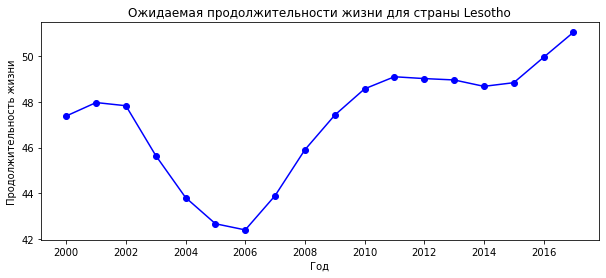

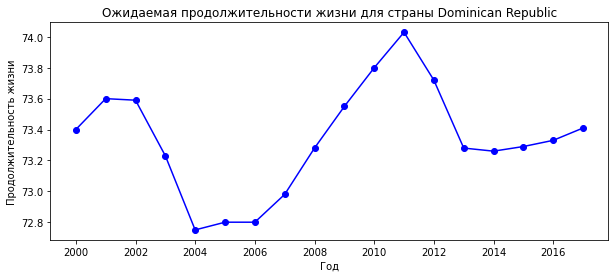

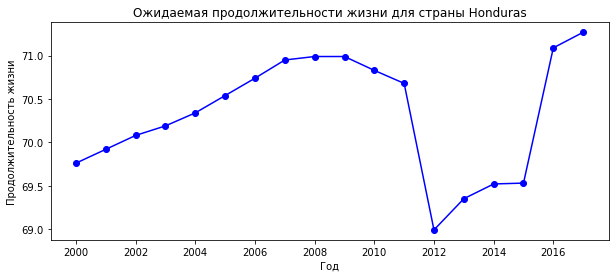

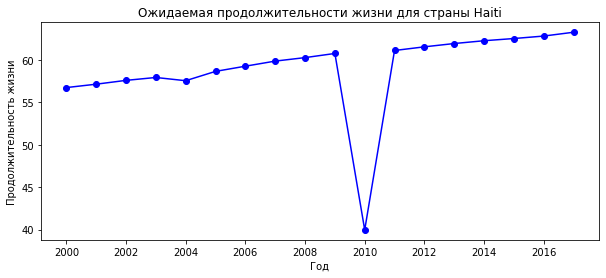

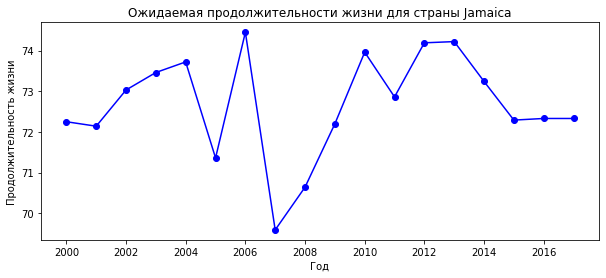

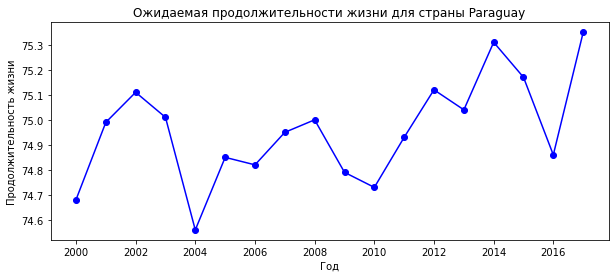

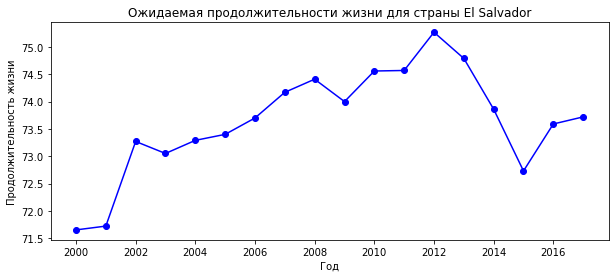

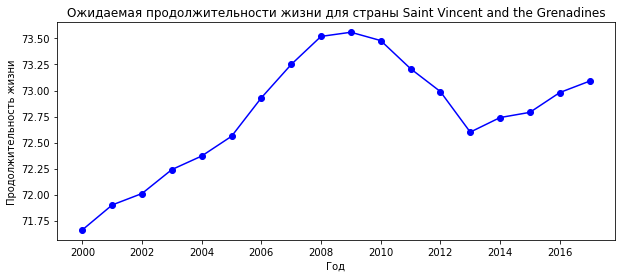

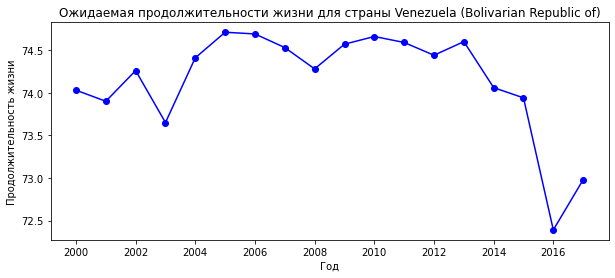

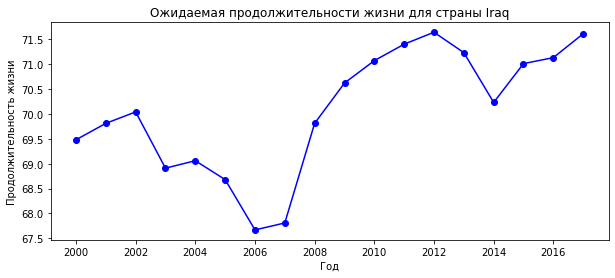

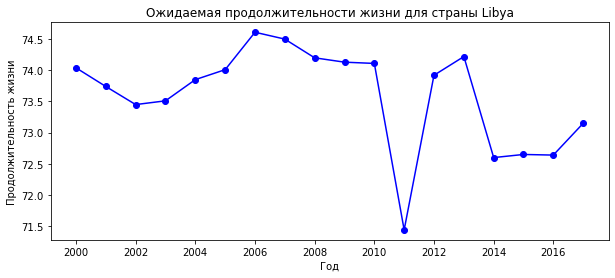

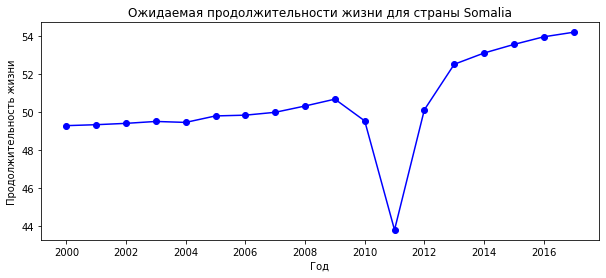

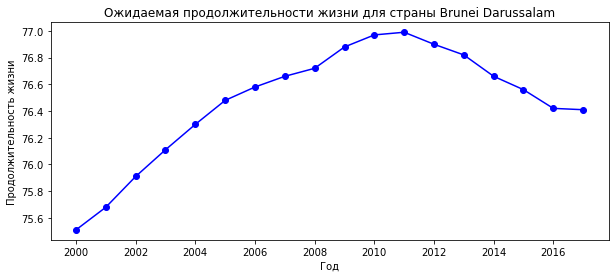

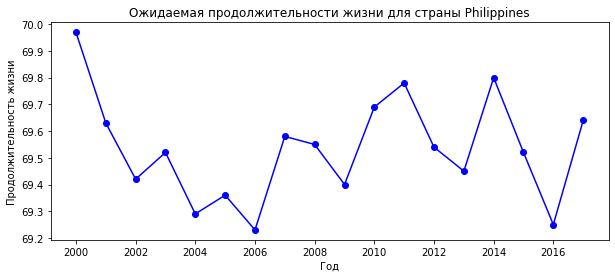

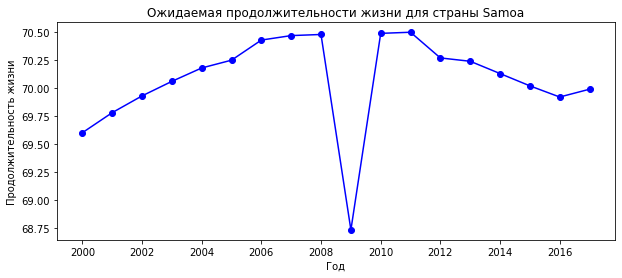

In [75]:
# Сформируем массив с кодами стран, в которых ряд продолжительности жизни стационарен
mask = stationarity_data['IsStationarity'] == True
stationarity_location_codes = stationarity_data[mask][F.SpatialDimValueCode.value].values


def display_location_time_series(code: str) -> None:
    """Выводит график временного ряда продолжительности жизни для страны

    Args:
        code (str): код страны
    """
    # Название страны
    location = get_location_by_code(code)   
    
    # Временной ряд для тренировочных данных
    location_time_series_train = get_location_time_series(train_data, code) 
    
    # Выводим график
    plt.figure(figsize=(10, 4))    
    plt.plot(location_time_series_train, marker="o", color="blue")    
    plt.title(f'Ожидаемая продолжительности жизни для страны {location}')
    plt.xlabel('Год')
    plt.ylabel('Продолжительность жизни');
    

for code in stationarity_location_codes:   
    display_location_time_series(code)

На этих графиках действительно не прослеживается ровный поступательный рост, \
как на большинстве графиков для других стран. \
Исключения пожалуй, составляют Гаити и Сомали. \
Там есть провалы за определенные года, но в целом наблюдается устойчивый рост.

## <a id='toc2_'></a>[Определение порядка интегрирования временных рядов ожидаемой продолжительности жизни по странам](#toc0_)

Дифференцируем ряды, которые не являются стационарными.\
И найдем порядок интегрирования для каждого ряда.

In [76]:
# Словарь, в котором будем запоминать порядки интегрирования
integration_order_dict = {
    F.SpatialDimValueCode.value: [], # Код страны
    'IntegrationOrder': [], # Порядок интегрирования ряда продолжительности жизни
}

# Для каждой страны определим порядок интегрирования ее ряда
for code in location_codes:   
    # Название страны
    location = get_location_by_code(code)  
    
    # Временной ряд для тренировочных данных
    location_time_series_train = get_location_time_series(train_data, code) 
    
    # Задаем переменную для временного ряда, который будем последовательно дифференцировать
    time_series_for_diff = location_time_series_train.copy()
    # Запомним длину временного ряда
    time_series_len = len(time_series_for_diff)
    # Порядок интегрирования
    integration_order = 0
    # Флаг, является ли ряд стационарным
    is_stationarity = is_time_series_stationarity(time_series_for_diff)
    
    # Пока ряд не стал стационарным и длина дифференцированного ряда
    while not is_stationarity and len(time_series_for_diff) > 3:
        # Прибавляем счетчик порядка интегрирования
        integration_order += 1
        # Дифференцируем ряд
        time_series_for_diff = time_series_for_diff.diff().dropna()
        try:
            # Проверяем стационарность ряда
            is_stationarity = is_time_series_stationarity(time_series_for_diff)
        except ValueError as e:
            print(f'Error: {code} - {location}')
            print(getattr(e, 'message', repr(e)))
    
    # Запоминаем порядок интергрирования ряда для данной страны
    integration_order_dict[F.SpatialDimValueCode.value].append(code)
    integration_order_dict['IntegrationOrder'].append(integration_order)

# Переведем полученные значения в таблицу
integration_order_data = pd.DataFrame(integration_order_dict)
integration_order_data.head()

,SpatialDimValueCode,IntegrationOrder
0,AGO,1
1,BDI,1
2,BEN,1
3,BFA,1
4,BWA,1


In [77]:
# Посмотрим сколько каких значений получилось
integration_order_data['IntegrationOrder'].value_counts()

IntegrationOrder
1    120
2     44
0     15
3      2
Name: count, dtype: int64

In [ ]:
# Сохраним полученную таблицу для дальнейшего использования
integration_order_data.to_csv('../data/integration_order.csv', index=False)